In [ ]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.optim as optim
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

drive.mount('/content/drive', force_remount=True)
project = '/content/drive/My Drive/final_project'
sys.path.append(project)

from RICODataset import *
from conv1d_enc_dec import *


Mounted at /content/drive


## Defining the data

Data shape: (102, 24)
Data reshaped to add feature: torch.Size([102, 24, 1])


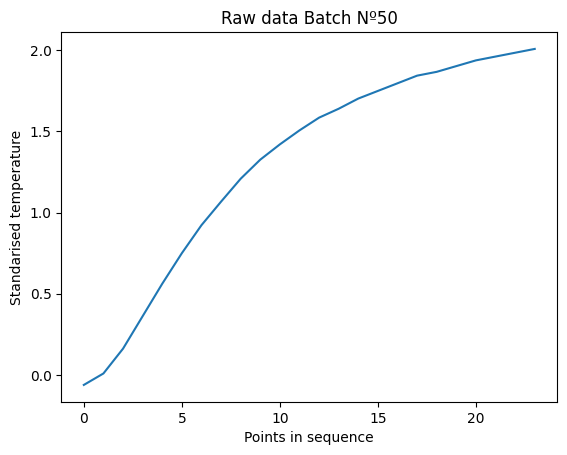

Processing data to size inputs and outputs for different forecast horizons... 
Inputs shape : torch.Size([4, 102, 1])
Targets shape : torch.Size([20, 102, 1])


In [ ]:
df_1 = pd.read_hdf(os.path.join(project, 'src/RICO1_Dataset.hdf'), key='all')

full_dataset = RICOFullDataset(data=df_1,
                               ori_seq_len=240,
                               tgt_seq_len=240,
                               stride=1,
                               channels=['B.RTD1'],
                               standardize=True)

dataset_1 = RICODataset(
    full_dataset,
    kind="full",
    get_every=10
)

data = pd.read_csv(os.path.join(project, 'src/rico1_full.tsv'), header=0, usecols=range(1,25))
data = np.array(data)
print(f'Data shape: {data.shape}')
data = torch.from_numpy(data)
data = data.reshape(data.shape[0], data.shape[1], 1)
print(f'Data reshaped to add feature: {data.shape}')

# Visualise raw data
idx = np.random.randint(0, data.shape[0])
plt.title(f'Raw data Batch Nº{idx}')
plt.xlabel('Points in sequence')
plt.ylabel('Standarised temperature')
plt.plot(data[idx])
plt.show()

print('Processing data to size inputs and outputs for different forecast horizons... ')

# shape (seq_len, batch_size, input_size)
forecast_horizon = 20

inputs, targets = data[:,:-forecast_horizon,:].permute(1,0,2).float(), data[:,-forecast_horizon:,:].permute(1,0,2).float()

print(f"Inputs shape :", inputs.shape)
print(f"Targets shape :", targets.shape)

## Convolutional encoder decoder

### Processing data

In [ ]:
data = data.float()
train_loader = DataLoader(TensorDataset(data), batch_size=16, shuffle=True)

### Defining the model

In [ ]:
enc = ConvEncoder(dropout=0)
dec = ConvDecoder(dropout=0)
model = ConvSeq2Seq(encoder=enc, decoder=dec)

### Training the model

Training ...: 100%|██████████| 600/600 [00:24<00:00, 24.26it/s, Loss : 1.6763]


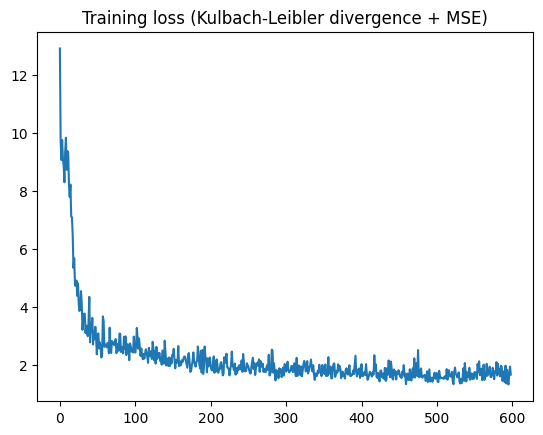

In [ ]:
n_epochs = 600

losses = []
bar = tqdm(range(n_epochs), total=n_epochs, desc="Training ...")
for epoch in bar:
    model, train_loss = train_epoch(model, epoch, train_loader=train_loader, target_len=forecast_horizon, device='cuda', print_progress=False)
    losses.append(train_loss)
    bar.set_postfix_str("Loss : {:.4f}".format(train_loss))
losses.pop(0)

model.to('cpu')

plt.title("Training loss (Kulbach-Leibler divergence + MSE)")
plt.plot(losses)
plt.show()

### Predicting

Input shape : torch.Size([24, 1])
Mean Squared Error: 1.8788093328475952


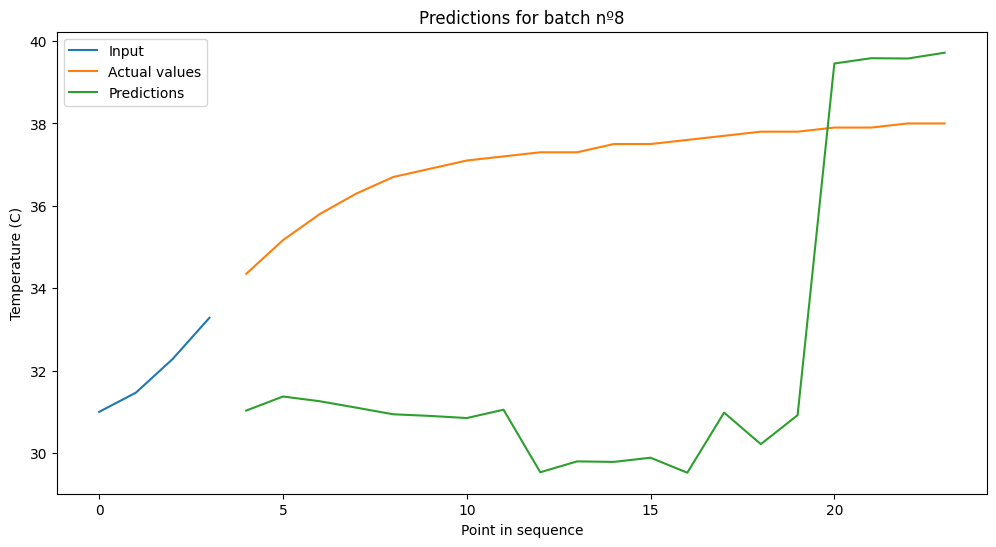

In [ ]:
idx = np.random.randint(0, len(data))
inputs = data[idx, :-forecast_horizon]
true = data[idx, -forecast_horizon:]
preds = model.predict(inputs, target_len=forecast_horizon)

# Step 4: Evaluate Performance
mse = mean_squared_error(true, preds)
print(f"Mean Squared Error: {mse}")

# Step 5: Plot Predictions
scaler = full_dataset.get_scaler()

pred_start = len(inputs)
pred_end = pred_start + len(preds)

pl_inputs = scaler.inverse_transform(inputs.reshape(-1,1))
pl_targets = scaler.inverse_transform(true.reshape(-1,1))
pl_predictions = scaler.inverse_transform(preds.reshape(-1,1))

plt.figure(figsize=(12, 6))
plt.plot(pl_inputs, label='Input')
plt.plot(np.arange(pred_start, pred_end),pl_targets, label='Actual values')
plt.plot(np.arange(pred_start, pred_end),pl_predictions, label='Predictions')
plt.title(f'Predictions for batch nº{idx}')
plt.xlabel('Point in sequence')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')
time = datetime.now().strftime("%d_%H%M")
plt.savefig(os.path.join(project,f'images/enc_dec_cnn/{time}_F20_{mse:.3f}.png'))
plt.show()